# Yelp Review Quality Prediction based on Text, Useful, Funny, and Cool Counts

The first step in our project is to import the data in order to analyze the dataset. We believe that analyzing the data before preparing the model is an important aspect of any machine learning task. Please provide the location of the Yelp dataset in the input box below after which, we will extract the reviews that are stricly related to restaurants.


In [2]:
!pip install gensim
!pip install keras
!pip install nltk
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install tensorflow==1.15
!pip install wordcloud

import gensim
from gensim.models import word2vec
from itertools import cycle
import json
from keras.utils import np_utils
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder
import sys
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SimpleRNN, LSTM
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.externals import joblib


nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package cess_cat is already up-

[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package unicode_samples i

**Please run then cell below and then follow the instructions provided hereafter. On running the cell a text input box will appear where you SHOULD enter the path to your dataset folder. A dropdown box to select one of the options from useful, funny or cool that you want to predict will also appear. Please select one of the options from 'useful', 'funny' or 'cool' in the dropdown box**

In [4]:
from IPython.display import display
from ipywidgets import widgets
text = widgets.Text()
display(text)

dataset_folder = '/Users/kldsouza/Documents/CS 544/code/project'

def handle_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global dataset_folder
        dataset_folder = change['new']

text.observe(handle_change)


dd_widget = widgets.Dropdown(
    options=['useful', 'funny', 'cool'],
    value='useful',
    description='Data Type:',
    disabled=False,
)

display(dd_widget)

data_type = 'useful'
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global data_type
        data_type = change['new']
        

dd_widget.observe(on_change)

Text(value='')

Dropdown(description='Data Type:', options=('useful', 'funny', 'cool'), value='useful')

Please verify that your folder_location and data type are as intended after running the cell below:

In [6]:
print(data_type)
print(dataset_folder)

useful
./yelp_dataset


## Data Extraction
In the following cells, we extract data from the review.json and business.json files. The main data that we will work with is the review text for each review along with its count for 'useful', 'funny' and 'cool'.

In [7]:
# functions for data extraction
def extract_data(business_data_folder, review_data_folder):
    output_data = {}
    with open(business_data_folder) as bd_handle:
        business = bd_handle.readline()

        while business:
            bd_data = json.loads(business)

            if bd_data['categories']:
                output_data[bd_data['business_id']] = {
                    'categories': [cat.strip() for cat in bd_data['categories'].split(',')],
                    'reviews': []
                }

            business = bd_handle.readline()

        bd_handle.close()

    with open(review_data_folder) as rd_handle:
        review = rd_handle.readline()

        while review:
            rv_data = json.loads(review)

            if rv_data['business_id'] in output_data:
                review = {}
                review['review_id'] = rv_data['review_id']
                review['text'] = rv_data['text']
                review['useful'] = rv_data['useful']
                review['funny'] = rv_data['funny']
                review['cool'] = rv_data['cool']
                output_data[rv_data['business_id']]['reviews'].append(review)

            review = rd_handle.readline()

        bd_handle.close()
        
    return output_data

def write_extracted_data(output_data, output_file):
    data_to_write = []
    for business_id in output_data:
        categories = output_data[business_id]['categories']

        if 'Restaurants' in categories and len(output_data[business_id]['reviews']) > 0:
            cat_to_write = ':'.join(categories)
            for review in output_data[business_id]['reviews']:
                review_id = review['review_id']
                text = review['text']
                useful = str(review['useful'])
                funny = str(review['funny'])
                cool = str(review['cool'])
                data_to_write.append({
                    'business_id': business_id,
                    'categories': cat_to_write,
                    'review_id': review_id,
                    'text': text,
                    'useful': useful,
                    'funny': funny,
                    'cool': cool
                })           

    with open(output_file, 'w') as of_handle:
        json.dump(data_to_write, of_handle)
        of_handle.close()

In [8]:
business_data_folder = os.path.join(dataset_folder, 'business.json')
review_data_folder = os.path.join(dataset_folder, 'review.json')
output_data = extract_data(business_data_folder, review_data_folder)
dataset_file = './dataset.json'
write_extracted_data(output_data, dataset_file)

Now, the data we need from review.json and business.json are stored in the file "dateset.json". Next, we will clean up the data and write the preprocessed datasets to "normalised_data.json".

## Data Analysis and Cleansing:

In the next cell, we analyze the data, specifically the distribution of values within the 'useful', 'funny' and 'cool' columns. We notice that the data is heavily skewed towards values between 0 to 5. Most of the values for 'useful', 'funny' and 'cool' lie between 0 and 20. There are outliers that occur in the data with some values going up to more than 500. 

In order to enable our model to accurately predict how 'useful', 'funny' or 'cool' a certain review is, we apply feature clipping on each of these columns. We also normalised these values so that they lie in the range of 0 to 1.

In [11]:
# functions for data preprocessing
def preprocess_data(data_file):

    df = pd.read_json(data_file)
    df['useful'] = df['useful'].astype(float)
    df['funny'] = df['funny'].astype(float)
    df['cool'] = df['cool'].astype(float)
    print("Dataset size: {0:d} rows x {1:d} columns".format(df.shape[0], df.shape[1]))

    vote_labels = ['useful', 'funny', 'cool']
    useful_min, useful_max = df['useful'].min(), df['useful'].max()
    funny_min, funny_max = df['funny'].min(), df['funny'].max()
    cool_min, cool_max = df['cool'].min(), df['cool'].max()

    # print out distribution of reviews by their vote counts
    for i in range(len(vote_labels)):
        ranges = np.arange(-1, 100, 10)
        counts = df.groupby(pd.cut(df[vote_labels[i]], ranges)).count()[vote_labels[i]]
        print(counts)
        print("Out of range counts: ", df.shape[0]-counts.sum())

    # save raw vote counts
    df['useful_raw'] = df['useful']
    df['funny_raw'] = df['funny']
    df['cool_raw'] = df['cool']
    # clip vote counts to specific ranges
    df['useful'] = df['useful'].clip(3.0, 27.0)
    df['funny'] = df['funny'].clip(3.0, 20.0)
    df['cool'] = df['cool'].clip(3.0, 24.0)

    # normalize data with min-max scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    useful_scaled = min_max_scaler.fit_transform(np.array(df['useful']).reshape(-1,1))
    df['useful'] = pd.DataFrame(useful_scaled)
    funny_scaled = min_max_scaler.fit_transform(np.array(df['funny']).reshape(-1,1))
    df['funny'] = pd.DataFrame(funny_scaled)
    cool_scaled = min_max_scaler.fit_transform(np.array(df['cool']).reshape(-1,1))
    df['cool'] = pd.DataFrame(cool_scaled)

    ranges = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    processed_data = []

    # balance dataset for each of vote category
    # make sure there is an even number of reviews in each increment of 0.1
    # from range 0.0 to 1.0
    for i in range(len(vote_labels)):
        counts = df.groupby(pd.cut(df[vote_labels[i]], ranges)).count()[vote_labels[i]]
        min_count = counts.min()
        new_df = pd.DataFrame()
        for j in range(10):
            lower = j/10
            upper = (j+1)/10 if j < 9 else 1.1
            new_data = df[(df[vote_labels[i]] >= lower) & (df[vote_labels[i]] < upper)]
            new_data = new_data.sample(frac=1)
            new_data = new_data.head(min_count)
            new_df = new_df.append(new_data)

        processed_data.append(new_df)
    
    return processed_data


def write_extracted_data(useful, funny, cool):
    output_dict = {
        'useful': useful.to_json(orient = 'records'),
        'funny': funny.to_json(orient = 'records'),
        'cool': cool.to_json(orient = 'records')
    }

    with open('normalised_data.json', 'w') as op_handle:
        json.dump(output_dict, op_handle)
        op_handle.close()

In [12]:
processed_data = preprocess_data(dataset_file)
write_extracted_data(processed_data[0], processed_data[1], processed_data[2])

INFO:root:Dataset size: 4201684 rows x 7 columns


useful
(-1, 9]     4148278
(9, 19]       40402
(19, 29]       7225
(29, 39]       2674
(39, 49]       1197
(49, 59]        623
(59, 69]        415
(69, 79]        245
(79, 89]        153
(89, 99]        119
Name: useful, dtype: int64
Out of range counts:  353
funny
(-1, 9]     4180159
(9, 19]       15647
(19, 29]       3281
(29, 39]       1236
(39, 49]        564
(49, 59]        282
(59, 69]        159
(69, 79]         89
(79, 89]         52
(89, 99]         41
Name: funny, dtype: int64
Out of range counts:  174
cool
(-1, 9]     4173089
(9, 19]       20001
(19, 29]       4550
(29, 39]       1778
(39, 49]        913
(49, 59]        477
(59, 69]        316
(69, 79]        179
(79, 89]        134
(89, 99]         95
Name: cool, dtype: int64
Out of range counts:  152


## Word2Vec Model:

In the next step, we cleanse each review by removing any punctuation and extra spaces. We also lowercase all the words in the review and remove any stopwords from the data. We then use this cleansed dataset to train a Word2Vec model

In [13]:
# functions for creating the word2vec model
def read_data(dataset_file):
    print("Reading data...")
    with open(dataset_file, 'r') as fh:
        full_data = json.load(fh)
        useful_data = pd.DataFrame(json.loads(full_data['useful']))
        funny_data = pd.DataFrame(json.loads(full_data['funny']))
        cool_data = pd.DataFrame(json.loads(full_data['cool']))
        all_data = useful_data.append([funny_data, cool_data])
    
    return useful_data, funny_data, cool_data, all_data


def clean_data(tokenized_data_file, all_data, tokenizer, stop_words):
    print("Cleaning data...")
    with open(tokenized_data_file, 'w') as fh:
        reviews = all_data['text'].tolist()

        for index in range(len(reviews)):
            review = reviews[index]
            no_tabs = str(review).replace('\t', ' ').replace('\n', '')
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
            multi_spaces = re.sub(" +", " ", alphas_only)
            no_spaces = multi_spaces.strip()
            clean_text = no_spaces.lower()
            sentences = tokenizer.tokenize(clean_text)
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]

            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    sentence = sentence.split(' ')
                    pruned_sentence = [word for word in sentence if word not in stop_words]
                    sentence = ' '.join(pruned_sentence)
                    if sentence: 
                        fh.write("%s\n" % sentence)

            if (index % 5000) == 0:
                fh.flush()
        fh.close()


def create_wve(tokenized_data_file):
    embedding_size = 256
    min_word_count = 50
    context = 30
    downsampling = 1e-2
    print("Creating word vectors...")
    model = word2vec.Word2Vec(
        word2vec.LineSentence(tokenized_data_file),
        size=embedding_size,
        min_count=min_word_count,
        window=context,
        sample=downsampling)
    model.init_sims(replace=True)
    model.save('./wve.model')
    
    return model

In [14]:
useful_data, funny_data, cool_data, all_data = read_data('normalised_data.json')
tokenized_data_file = './tokennized.txt'
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stop_words = nltk.corpus.stopwords.words()
clean_data(tokenized_data_file, all_data, tokenizer, stop_words)
wve_model = create_wve(tokenized_data_file)

INFO:root:Reading data...
INFO:root:Cleaning data...
INFO:root:Creating word vectors...
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 78423 words, keeping 9946 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 171249 words, keeping 16538 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 263537 words, keeping 21746 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 354512 words, keeping 26160 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 452696 words, keeping 30651 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 546753 words, keeping 34497 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 647625 words, keeping 38324 word types
INFO:

INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 20.11% examples, 467501 words/s, in_qsize 5, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 34.73% examples, 539130 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 51.36% examples, 504196 words/s, in_qsize 6, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 69.39% examples, 561371 words/s, in_qsize 4, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 86.92% examples, 601844 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 2 : training on 5148685 raw words (4681713 effective words) took 7.6s, 616810 effective words/s
INFO:gensim.models.base_any2vec:EP

## Regression with LSTM

In the following sections, we attempt to predict the preprocessed values of labels (‘useful’, ‘funny’, and ‘cool’) for each review. In order to do that, we create a recurrent neural network model with LSTM units with review text represented as word vector embeddings for the input and a predicted value for the output.

The model below also includes another version which does binary classification instead of regression, and we will experiment with both versions.


In [ ]:
# implementation of LSTM model
class LSTMModel:
    def __init__(self, data_file, label):
        self.data_file = data_file
        self.label = label
        self.df = []
        self.text = []
        self.num_reviews = 0
        self.max_length = 0
        self.embedding_dim = 250
        self.batch_size = 128
        self.lstm_dim = 100
        self.text_embedding = None
        self.model = None
        self.train_text = None
        self.test_text = None
        self.train_labels = None
        self.test_labels = None

    def read_data(self):        
        # read normalized datatsets
        with open(self.data_file, 'r') as f:
            full_data = json.load(f)
            self.df = pd.DataFrame(json.loads(full_data[self.label]))
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def create_input_embedding(self):
        # preprocess text
        # remove newlines, spaces, and punctuations
        # lowercase words and separate by commas
        for i in range(self.df.shape[0]):
            line = gensim.utils.simple_preprocess(self.df['text'].iloc[i])
            self.text.append(line)

        length = max([len(s) for s in self.text])
        self.num_reviews = len(self.text)
        
        # convert text to word vector embedding
        text_embedding = np.zeros((self.num_reviews, length, self.embedding_dim))
        for i in range(len(self.text)):
            idx = 0
            for j in range(len(self.text[i])):
                # get jth word of ith review
                word = self.text[i][j]
                # if word is in vocab, add its vector embedding, else skip
                if word in wve_model.wv.vocab:
                    vec = wve_model[word]
                    text_embedding[i,idx,:] = vec
                    idx += 1
            if idx > self.max_length:
                self.max_length = idx
        
        self.text_embedding = text_embedding[:,:self.max_length,:]
        print("Text embedding size: ", text_embedding.shape)
        
    def build_regression_model(self):
        # construct regression model
        self.model = Sequential()
        self.model.add(Dense(self.batch_size, input_shape=(self.max_length, self.embedding_dim)))
        self.model.add(Dense(300, activation='relu'))
        self.model.add(Dense(150, activation='relu'))
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss='mae', 
                           optimizer='adam', 
                           metrics=['mae', 'acc'])
        
    def train_regression_model(self):
        labels = self.df[self.label].values
        self.train_text, self.test_text, self.train_labels, self.test_labels = \
            train_test_split(self.text_embedding, labels, test_size=0.3)

        print("Train data size: ", self.train_text.shape, self.train_labels.shape)
        print("Test data size: ", self.test_text.shape, self.test_labels.shape)

        i = self.num_reviews // self.batch_size
        i *= self.batch_size
        self.train_text = self.train_text[:i,:,:]
        self.train_labels = self.train_labels[:i]

        self.model.fit(self.train_text,self.train_labels, 
                  batch_size=self.batch_size, shuffle=True, epochs=7)
        
    def test_regression_model(self):
        self.model.evaluate(self.test_text, self.test_labels)
        
    def build_classification_model(self):
        print("Building model...")
        # construct classification model
        self.model = Sequential()
        self.model.add(Dense(self.batch_size, input_shape=(self.max_length, self.embedding_dim)))
        self.model.add(Dense(300, activation='relu'))
        self.model.add(Dense(150, activation='relu'))
        self.model.add(LSTM(self.lstm_dim, return_sequences=False))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['acc'])
        
    def train_classification_model(self):
        # convert labels to 0 and 1
        # 0 = not useful, 1 = useful
        binary_labels = []
        raw_labels = self.df[self.label].values
        for l in raw_labels:
            if l < 0.5:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        encoder = LabelEncoder()
        encoder.fit(binary_labels)
        labels = encoder.transform(binary_labels)

        # divide into train and test sets
        self.train_text, self.test_text, self.train_labels, self.test_labels = \
            train_test_split(self.text_embedding, labels, test_size=0.3)

        print("Train data size: ", self.train_text.shape, self.train_labels.shape)
        print("Test data size: ", self.test_text.shape, self.test_labels.shape)

        i = self.num_reviews // self.batch_size
        i *= self.batch_size
        self.train_text = self.train_text[:i,:,:]
        self.train_labels = self.train_labels[:i]

        print("Training model...")
        self.model.fit(self.train_text,self.train_labels, 
                  batch_size=self.batch_size, shuffle=True, epochs=7)
        
    def test_classification_model(self):
        print("Predicting...")
        self.model.evaluate(self.test_text, self.test_labels)
        pred = self.model.predict(self.test_text)
        pred[pred < 0.5] = 0
        pred[pred >= 0.5] = 1
        
        print(classification_report(self.test_labels, pred)) 

First, we create an instance of the regression model. After reading the input dataset, we convert the preprocessed text data to word vector embeddings using our Word2Vec model. We then build the LSTM model, feed the embeddings as input to train it, and evaluate it with the test set.

In [ ]:
LSTM_reg_model = LSTMModel('normalised_data.json', data_type)
LSTM_reg_model.read_data()
LSTM_reg_model.create_input_embedding()
LSTM_reg_model.build_regression_model()
LSTM_reg_model.train_regression_model()
LSTM_reg_model.test_regression_model()

Next, we repeat the same steps to create a binary classification version of our LSTM model. Again, we train and evaluate it.

In [ ]:
LSTM_class_model = LSTMModel('normalised_data.json', data_type)
LSTM_class_model.read_data()
LSTM_class_model.create_input_embedding()
LSTM_class_model.build_classification_model()
LSTM_class_model.train_classification_model()
LSTM_class_model.test_classification_model()

## Model with Cluster Inputs:
As seen above, the accuracy on using a vanilla LSTM model is low. We will now try a different approach wherein we change the input features that we feed into the network. The thinking behind this is that a large portion of the review text contains words that are irrelevant or make no contribution towards predicting whether a review is 'useful', 'funny' or 'cool'. Therefore, instead of converting the words in the review into word vector embeddings and feeding these as input to the network, we are going to handpick a subset of words that we think are crucial to having a good review. For example, if I decide that the words: 'cook', 'bake' and 'fry' are going to be words that determine whether a review is useful or not, then for each review, I will look at each word within the review and determine which of the above three words it is closest to in terms of its word vector embedding. Let us say that my review contained three words that are closest to 'cook', four closest to 'bake' and 'one closest to 'fry'. My input to the network is then the word vector embeddings for 'cook', 'bake' and 'fry weighted by how many words in the review were closest to them.

In order to determine what words I should use as crucial words, I take the word vector embeddings of the whole vocabulary that we calculated above and run K-Means clustering on these embeddings with the number of clusters set to 120. The intuition behind doing this is that, we can seperate the vocabulary into 120 different groups, wherein each group represents some kind of terminology related to restaurants and cooking. This should become clear on running the following code.


In [15]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

normalised_data_path = './normalised_data.json'
print("Clustering work vectors...")
clustering = KMeans(n_clusters = 120, init='k-means++')
clustering_index = clustering.fit_predict(wve_model.wv.vectors)
joblib.dump(clustering, './cluster.model')
cluster_centers = clustering.cluster_centers_
center_labels = [wve_model.wv.most_similar(positive=[vector], topn=1)[0][0] for vector in cluster_centers]
centroid_map = dict(zip(wve_model.wv.index2word, clustering_index))

INFO:root:Clustering work vectors...


In [16]:
print(center_labels)


['avenue', 'artist', 'tend', 'crispness', 'behavior', 'parmesan', 'jumbo', 'safety', 'raisins', 'security', 'michael', 'benedict', 'alex', 'program', 'cities', 'candied', 'established', 'asparagus', 'influenced', 'holding', 'courteous', 'giant', 'hakkasan', 'buying', 'flavorless', 'elements', 'dulce', 'god', 'luxury', 'earthy', 'writing', 'shower', 'hamachi', 'bookmarked', 'cheeseburger', 'band', 'amidst', 'jalapenos', 'utensils', 'carnitas', 'crave', 'critical', 'constant', 'kabuto', 'knowing', 'hang', 'twenty', 'fight', 'bagels', 'gold', 'varieties', 'february', 'hopefully', 'responded', 'cleveland', 'sirloin', 'handful', 'margherita', 'unacceptable', 'professionalism', 'lattes', 'weekdays', 'omg', 'browse', 'rotisserie', 'northwest', 'loin', 'coated', 'typical', 'shanghai', 'entrance', 'sodas', 'complain', 'month', 'includes', 'whiskey', 'wearing', 'tout', 'feels', 'surprisingly', 'sweetened', 'misters', 'servings', 'https', 'ceiling', 'caesars', 'waste', 'girlfriend', 'shit', 'show

As we can see in the above cell, our cluster centers happen to be terms that are related to food. In order to demonstrate how each cluster center might contribute towards determining whether a review is useful or not, we have plotted the wordclouds for four of the centers below:

In [17]:
print("Getting top words for each cluster...")
tree = KDTree(wve_model.wv.vectors)
closest_points = [tree.query(np.reshape(x, (1, -1)), k=20) for x in cluster_centers[0:4]]
closest_words_ids = [x[1] for x in closest_points]
closest_words = {}
closest_ids = {}

for i in range(0, len(closest_words_ids)):
    closest_words['Cluster #' + str(i)] = [wve_model.wv.index2word[j] for j in closest_words_ids[i][0]]
    closest_ids['Cluster #' + str(i)] = [wve_model.wv[wve_model.wv.index2entity[j]] for j in closest_words_ids[i][0]]

wd_df = pd.DataFrame(closest_words)
id_df = pd.DataFrame(closest_ids)
top_words = wd_df
top_ids = id_df

INFO:root:Getting top words for each cluster...


INFO:root:Word clouds for each cluster: 
INFO:root:Word clouds for each cluster: 
INFO:root:Word clouds for each cluster: 
INFO:root:Word clouds for each cluster: 


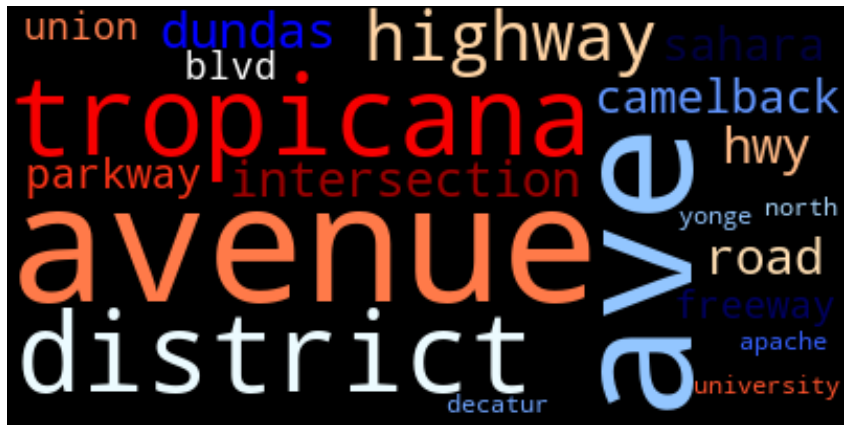

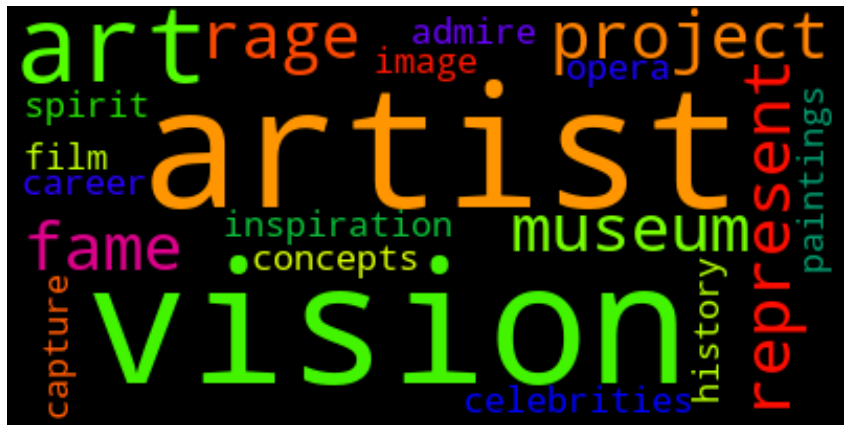

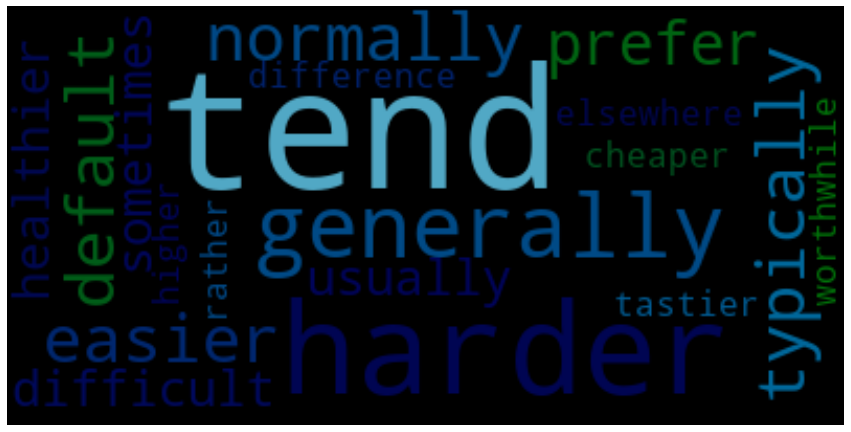

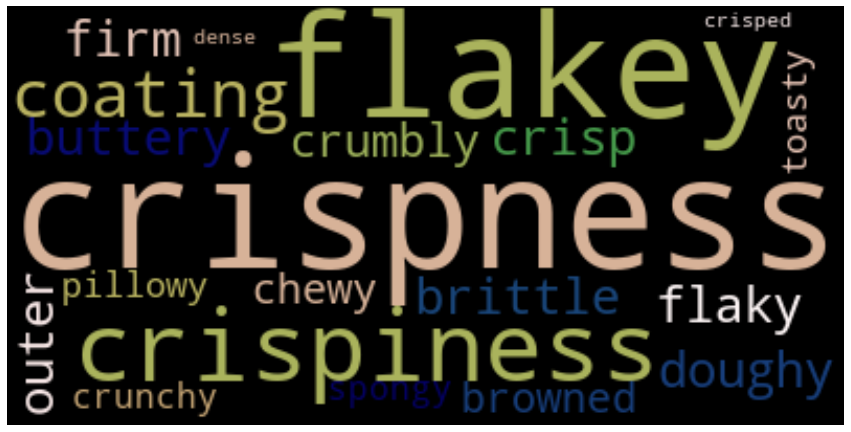

In [18]:
def display_cloud(cluster_index, color_map):
    print("Word clouds for each cluster: ")
    if len(top_words['Cluster #' + str(cluster_index)])>0:
        wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=color_map)
        wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_index)]]))
        plt.subplots(1,1, figsize=(15, 15))
        plt.plot()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
#         plt.savefig('clusters/cluster_' + str(self.wve_model.most_similar(positive=[self.cluster_centers[cluster_index]], topn=1)[0][0]), bbox_inches='tight')



cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(4):
    col = next(cmaps);
    display_cloud(i, col)

plt.show()

In [19]:
print("Saving cluster centroids...")
output = {}
output['embedding_size'] = 256
output['num_clusters'] = 120
output['cluster_centers'] = cluster_centers.tolist()

with open('./cluster_data.json', 'w') as of_handle:
    json.dump(output, of_handle)
    of_handle.close()

INFO:root:Saving cluster centroids...


In the next section, we process our review text into a form where for each review, we convert the review into its weighted centroid embedding form that was described earlier. This section of the code takes a **considerable time to run**.

In [22]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

class ClusterModelInput:
    def __init__(self):
        self.wve_model = gensim.models.Word2Vec.load('./wve.model')
        self.cluster_data_file_name = './cluster_data.json'
        self.dataset_location = './normalised_data.json'
        self.cluster_data = None
        self.useful_data = None
        self.tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        self._stop_words_ = nltk.corpus.stopwords.words()
        self.clustering = joblib.load('./cluster.model')
        self.train_test_data_file_path = './train_test_data.json'

    def load_data(self):
        with open(self.cluster_data_file_name) as fh:
            self.cluster_data = json.load(fh)
            fh.close()

        with open(self.dataset_location, 'r') as fh:
            full_data = json.load(fh)
            self.useful_data = pd.DataFrame(json.loads(full_data[data_type]))
            fh.close()

    def prepare_input(self):
        df = self.useful_data.sample(frac=1).reset_index(drop=True)
        text_input = df['text'].tolist()
        transformed_text = []
        cluster_count = []

        for _, review in enumerate(text_input):
            print('Currently processing review %s:', review)
            no_tabs = str(review).replace('\t', ' ').replace('\n', '')
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
            multi_spaces = re.sub(" +", " ", alphas_only)
            no_spaces = multi_spaces.strip()
            clean_text = no_spaces.lower()
            sentences = self.tokenizer.tokenize(clean_text)
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]
            review_weights = range(self.cluster_data['num_clusters'])
            review_weights = dict(Counter(review_weights))
            review_weights = dict.fromkeys(review_weights, 0)

            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    sentence = sentence.split(' ')
                    pruned_sentence = [self.get_cluster_bucket(word) for word in sentence if word not in self._stop_words_]

                    if len(pruned_sentence) > 0:
                        pruned_sentence = dict(Counter(pruned_sentence))
                        for key in review_weights:
                            if key in pruned_sentence:
                                review_weights[key] = review_weights[key] + pruned_sentence[key]
            
            sorted_review_weights = np.array([review_weights[key] for key in sorted(review_weights.keys())])
            final_weights = self.cluster_data['cluster_centers'] * sorted_review_weights[:, None]
            transformed_text.append(final_weights)
            cluster_count.append(sorted_review_weights)
        
        self.input_data = np.array(transformed_text)
        self.rf_input_data = np.array(cluster_count)
        self.labels = np.array(df[data_type].tolist())
        self.alternate_labels = np.array(df[data_type + '_raw'].tolist())

    def get_cluster_bucket(self, word):
        if word in self.wve_model.wv.vocab:
            word_embedding = self.wve_model.wv[word]
            return self.clustering.predict([word_embedding])[0]
        else:
            return -1

    def save_training_data(self):
        rows, _ = self.useful_data.shape
        split_point = int(math.floor(rows * 0.7))
        train_input = self.input_data[0:split_point, :]
        test_input = self.input_data[split_point:rows, :]
        rf_train_input = self.rf_input_data[0:split_point, :]
        rf_test_input = self.rf_input_data[split_point: rows, :]
        train_labels = self.labels[0:split_point]
        test_labels = self.labels[split_point:rows]
        train_alternate_labels = self.alternate_labels[0:split_point]
        test_alternate_labels = self.alternate_labels[split_point:rows]
        
        class_labels_train = []
        for l in train_labels:
            if l < 0.33:
                class_labels_train.append('low')
            elif l >= 0.33 and l < 0.66:
                class_labels_train.append('medium')
            elif l >= 0.66 and l <= 1.0:
                class_labels_train.append('high')
        
        encoder_train = LabelEncoder()
        encoder_train.fit(class_labels_train)
        encoded_labels_train = encoder_train.transform(class_labels_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        one_hot_labels_train = np_utils.to_categorical(encoded_labels_train)
        
        class_labels_test = []
        for l in test_labels:
            if l < 0.33:
                class_labels_test.append('low')
            elif l >= 0.33 and l < 0.66:
                class_labels_test.append('medium')
            elif l >= 0.66 and l <= 1.0:
                class_labels_test.append('high')

        encoder_test = LabelEncoder()
        encoder_test.fit(class_labels_test)
        encoded_labels_test = encoder_test.transform(class_labels_test)
        # convert integers to dummy variables (i.e. one hot encoded)
        one_hot_labels_test = np_utils.to_categorical(encoded_labels_test)
        
        oh_class_labels_train = []
        for l in train_labels:
            if l < 0.5:
                oh_class_labels_train.append('not ' + data_type)
            elif l >= 0.5:
                oh_class_labels_train.append(data_type)
        
        oh_encoder_train = LabelEncoder()
        oh_encoder_train.fit(oh_class_labels_train)
        oh_encoded_labels_train = oh_encoder_train.transform(oh_class_labels_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        oh_one_hot_labels_train = np_utils.to_categorical(oh_encoded_labels_train)
        
        oh_class_labels_test = []
        for l in test_labels:
            if l < 0.5:
                oh_class_labels_test.append('not ' + data_type)
            elif l >= 0.5:
                oh_class_labels_test.append(data_type)

        oh_encoder_test = LabelEncoder()
        oh_encoder_test.fit(oh_class_labels_test)
        oh_encoded_labels_test = oh_encoder_test.transform(oh_class_labels_test)
        # convert integers to dummy variables (i.e. one hot encoded)
        oh_one_hot_labels_test = np_utils.to_categorical(oh_encoded_labels_test)
        
        return (train_input, test_input, train_labels, test_labels, one_hot_labels_train, one_hot_labels_test, rf_train_input, rf_test_input, oh_one_hot_labels_train, oh_one_hot_labels_test)

model = ClusterModelInput()
model.load_data()
model.prepare_input()
train_input, test_input, train_labels, test_labels, train_alternate_labels, test_alternate_labels, rf_train_input, rf_test_input, oh_train_labels, oh_test_labels = model.save_training_data()

INFO:gensim.utils:loading Word2Vec object from ./wve.model
INFO:gensim.utils:loading wv recursively from ./wve.model.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loading vocabulary recursively from ./wve.model.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from ./wve.model.trainables.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded ./wve.model
INFO:root:Currently processing review Their address will tell you Carson Kitchen is located on 6th street, but you'll have to turn the corner onto Carson to find the entrance right next door to O Face Doughnuts. The lack of signage makes it difficult to find, but it's totally worth the search. I've tried two other Kerry Simon restaurants and wasn't wowed. This place, however, lives up to the hype.

The menu is full of small and large plates of  Simon's re-imagining of comfort food. Deviled eggs ($8) are re

INFO:root:Currently processing review Great little shop, love the decor and the 2 guys behind the counter were very desirable. That aside, the Sandwiches were delish!  

I had the Vermonter, with the most amazing mayo-like sauce I have ever swallowed...
The atmosphere is comfortable and I will definitely be back again and again, if not for eye candy then at least for a little lunch.:
INFO:root:Currently processing review Nothing fancy about the restaurant but the food and the service was good. 
Actually, it was a little spicy for me. I wish I would have asked for mild. I was breaking a sweat and my mouth was burning, however very good and great ingredients.
The 89' Riesling that I had with my meal was excellent. (brought to the restaurant.) 
Would definitely go back for more!:
INFO:root:Currently processing review At the risk of tiptoeing into overly used Yelp cliché territory, SUSHISAMBA serves food with a twist. I've been to SUSHISAMBA restaurants in several cities including Miami Be

INFO:root:Currently processing review Every time my mother-in-law comes into town we inevitably end up at the mall and usually pop into the cafe to eat. We love coming here because we are never disappointed. I have been here several times and back home we were regulars at the Nordstrom Cafe in Scottsdale.

I am a creature of habit so I always order my favorites at regular dining spots. I ordered my usual Parm Chicken Salad.  Crispy chicken with lots of avocado made fresh. The tomato basil soup is another favorite and this comes with a kids grilled cheese sandwich meal that my son always orders.  All of the other menu items are very good too (pizza, panini, pasta).  My mother in law had the salmon salad and she said it was very good. 

We had excellent service.  We asked for extra Parmesan crisps to be brought out (which are served with the soup) and they brought out extra.  I also had a glass of wine with my salad and beer is served here also. Waitress comes by to refill ice-tea. Choco

INFO:root:Currently processing review Most Yelp regulars have figured out that customized, wood-fired pizza on an assembly line is one of the hottest fast-casual food trends right now. There are places like this everywhere, but do our pieologists have what it takes to break the mold? 

This is the thinnest thin crust I have ever seen. Anywhere. It's not necessarily crunchy, either, but hard, rubbery, and tasteless. It's like a minimalist vessel that simply acts as a delivery system for delicious toppings. In their defense, however, some pizzas are surprisingly low in calories. Half of one was good enough for me...and that logged in less than 500! Not bad. 

I was craving spicy, so I went with the buffalo chicken pizza...this is the best buffalo pizza I've had! I was worried there wouldn't be enough sauce, but whatever they're using is actually spicy. Really gets the job done. Cheese is high quality, and so was the chicken. 

I tried their side of "savory herb strips", a vague name I'm 

INFO:root:Currently processing review This was the worst dining experience I have ever had. EVER. I am a giant fan of Fox Restaurant Concepts and the first time I went to The Yard - I was so excited. Conceptually, the design is stellar. However, I will not be returning. I called to set a reservation of 12 for my birthday this past Saturday. I was told they did not take reservations. Turns out, they do. I have had several friends that have been told they do not take reservations and another set of friends that say that they have actually made reservations. I found out upon my arrival, they do indeed take reservations. They need to get their story straight.

Anyway, we show up at 3:15pm and put our name on a list for 12. We were told 1 hour to 1.5 hour wait. No problem, we went to the bar. While at the bar, the staff was literally fumbling over one another and it was not even that busy. The entire bar (people we did not even know) were all complaining about the time it took to order one 

INFO:root:Currently processing review So I wound up at the breadfruit with the Yelp Az International Supper Club (my 1st time, and glad I went, look forward to many other eating adventures to come!) on a Thursday night, 1st off how come no one has written about the parking? I'm from Chandler and don't go downtown that often, and didn't bring change with me for the parking meters so wound up in a parking lot not too far from the restaurant and paid 5 bucks for less than 2 hours.  Oh well, I'm putting it out their now, bring change to feed the meters.

I have mixed feelings on the Breadfruit and I'll explain, the food, which was good, I enjoyed it and did eat it, I think is little overpriced, for example the pineapple upsidedown cake I order, that was maybe 4 bites was 9.50, that was more than my pina colada, come on now, maybe they want you to drink to forget the prices lol. Also people were saying the size of the entrée dishes were small, but for me it was perfect, I think it's because

INFO:root:Currently processing review huh.... #1 on "Hot on Yelp" on the Yelp homepage for Las Vegas. I was expecting some expensive 5-star restaurant. But when I think about it, Earl of Sandwich is something I always crave on my Vegas trip.

Not only is it the best drunk food (opened late), it's also perfect for lunch and dinner. It's located in the casino part (not the mile shops) of Planet Hollywood. 

Every time I come here, my go-to sandwich is the cannonball. Delicious bread, meatballs, marinara, and gooey cheeeeese. Simple, yet gorgeous.
My boyfriend and I shared one as an after-club snack and on the last bite of my boyfriend's sandwich, he dropped the last meatball on the floor. In all honesty, it was the saddest part of our night. So sad that we talked about it the next morning, very true story.

It's that good, man.:
INFO:root:Currently processing review My bowl overfloweth with vegetables, and for this, I am thankful! Yes, I have a special place in my stomach for pho spots t

INFO:root:Currently processing review I have made it to zips many times, and it used to be one of my go to places for a relaxing evening to just hang out, play pool, and have some beer. Sadly, the service has continued to decline. I have had a lot of trouble when they have not put in our orders or forgetting about us while we were on the patio. It's sad because I love the sweet jalapeño burger and their wings. Maybe I'll give it a try again. I would suggest at least going to a different location:
INFO:root:Currently processing review A healthier choice for dinner. Love that this is one of my sons favorite choices for dinner as well. 

Greeted with a friendly hello and smile as we walk in. Establishment is clean, open and inviting. 

First you pick roll (sushi burrito) or bowl. Various bases offered rice, tofu, chips or salad. As far as proteins (fish) they have tons! Yellowtail is our favorite! Then on to the sauces. We have been here a few times so we try new concoctions but tend to f

INFO:root:Currently processing review We loved our stay here!

Stayed for two nights. Upon check-in, we were graciously helped by Kim. We arrived around 11 am, check-in is not until 3 pm. While we chatted with Kim, he let us know our room was not ready but would find us a room that was. Lo and behold we were upgraded to a Resort King strip view room on the 21st floor. Kim even provided us $30 in food and beverage credits for our stay! What hospitality!

The hotel is conveniently and beautifully laid out, you check in facing their  20,000 gallon saltwater tank behind the front desk, walk through the cascading waterfall in the atrium, through the noticeably, clean smelling casino, past the Pantry (their 24-hour diner-esq restaurant) and up some crisp, speedy elevators.

The room is 394 sq ft but felt larger due to the flush TV and entertainment systems. The bed was very comfortable (Posturepedic Pillow-Top Mirage Serenity Bed by Sealy® as stated per their website), as were the pillows. T

INFO:root:Currently processing review This used to be a Rosetti's. They recently changed hands, and became Sweet home Chicago. The first time we went there, we hadn't been waited on in 15 minutes, (they weren't busy) and we walked out. We thought they had just changed hands, and thought we would give them another chance. Three days before a UFC event, my wife called and asked if they took reservations. They assured her they did, so she made reservations for 8 pm the night of the fight for dinner. She called back the morning if the event and spoke with Dillon, confirmed the 8 pm reservation, and he said we'll see you at 8:00 tonight. We rolled in at 7:50, told the hosted we had reservations for 8:00. She disappeared for a few minutes, came back and said that they didn't take reservations, and they had no seats. When we told her we had made and confirmed the reservations with two different people, she said she didn't care, and they didn't have a table available. Needless to say we won't 

INFO:root:Currently processing review I was here with a group of friends last weekend and for a Friday night they were not busy at all. That should have been for first clue that the place was just not that great but it was still fairly early. The service was extremely slow, there was however another large group in there enclosed area doing only God knows what...the waitresses bless their souls must have been pulling double duty in both areas because we rarely saw them. I had to repeatedly ask for refills...and flag her down when we had been long since done to finish paying my bill and tip. 
However we got lucky and made the HH just in time...or so I thought.
I searched the menu ahead of time and the one dish I decided on, they did not have. Beers that were listed they also did not have. I went with the Bearded Blonde Beer, not bad and the pretzel appetizer, can't go wrong with that. The cheese was oily and slid right off the pretzel...and well the Grey Poupon like spicy mustard you'll 

INFO:root:Currently processing review A five star experience all the way.

I came with a group of gals and we were running super late for our reservation. They were very gracious and held our table for us even though we were running about 30 minutes behind schedule. You try gathering six ladies!!! It's tough!!

We went family style and decided to share everything we ordered. Our server asked us if we wanted to double a few things that came as a trio, since we had six in our party. We thought it was a great idea, but he doubled everything which was way too much food and wasn't cheap. That would be the only part of the experience that wasn't stellar. I never like to feel mislead or taken advantage of and I felt both of those things. Otherwise, the service was stellar. The wine was flowing, my water was always full, and the food was timed very well.

Highlights were the scallops and the avocado toast. Call me a millenial, but avocado toast has my heart. The bone marrow was mouthwatering w

INFO:root:Currently processing review It's a bar that serves burgers, but not the kind of place where you struggle to get a seat. Just walk up to the hostess and you're good. The booths have TVs where you can watch sports center or whatever game of the day is on. They have a full bar, a lot of beers on tap, and an extensive shakes with booze menu. 

Foodwise, there's something on there called a billionaire burger with Kobe (style) beef, Foie Gras, and truffle mayo. 

I just got a baguette burger. It was really really good. 
My paranoia when it comes to baguettes is that i'm going to get some stale loaf that cuts the roof of my mouth, or gives my teeth a workout. It was actually almost an amazing piece of bread. It if had been only a tiny bit softer, it would've been the best baguette burger of my life. Honestly, it was pretty close. 

The meat was cooked perfectly. There was enough fat in the ground beef for it to ooze flavor when I bit into it. The Gruyere was melted evenly and just h

KeyboardInterrupt: 

Now that we have our input data and labels in the correct format, we will train a deep LSTM model to classify the data into one of three categories, wherein the values of 0 to 0.3 for 'useful', 'funny' and 'cool' fall into a class called 'low', the values for 0.3 to 0.6 fall into another class called 'medium' and finally the values for 0.6 to 1.0 fall into a class called 'high'. We thus hope to classify a given review as being low, medium or high in terms of 'usefulness', 'funnyness' or 'coolness'.

In [ ]:
import tensorflow as tf
import json
import tensorflow.keras.backend as K
from keras.activations import softmax
import numpy as np

class ClusterModel:
    def __init__(self, train_data, test_data, train_labels, test_labels):
        self.model = None
        self.embedding_size = None
        self.num_clusters = None
        self.cluster_data_file_name = './cluster_data.json'
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.read_data()
        self.create_model()
        self.train_model()
        self.predict_and_evaluate()

    def create_model(self):
        print('Building model...')
        model = tf.keras.Sequential()
#         input_layer = tf.keras.layers.InputLayer(batch_size=128, input_shape=(self.num_clusters, self.embedding_size))
#         model.add(input_layer)

        dense_layer = tf.keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_uniform', input_shape=(self.num_clusters, self.embedding_size))
        model.add(dense_layer)
        # dense_middle = tf.keras.layers.Dense(500, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        # model.add(dense_middle)
        dense_layer_2 = tf.keras.layers.Dense(300, activation='relu')
        model.add(dense_layer_2)
        flatten_layer = tf.keras.layers.Flatten()
        model.add(flatten_layer)
        dense_layer_3 = tf.keras.layers.Dense(3, activation='softmax')
        model.add(dense_layer_3)

        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse', 'mae'])
        self.model = model
        print(model.summary())

    def read_data(self):
        print('Reading data...')
        with open(self.cluster_data_file_name) as fh:
            data = json.load(fh)
            self.embedding_size = data['embedding_size']
            self.num_clusters = data['num_clusters']
            fh.close()
    
    def train_model(self):
        print('Training model...')
        self.model.fit(self.train_data, self.train_labels, batch_size = 128, epochs = 5, validation_split = 0.3)

    def predict_and_evaluate(self):
        print('Predicting...')
        pred = self.model.predict(self.test_data)
        pred_labels = []
        true_labels = []
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_data:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels))
        
        
cluster_model = ClusterModel(train_input, test_input, train_alternate_labels, test_alternate_labels)

As we can see above, we get a marginal improvement in accuracy. Next, we tried using a random forest to classify this data. Random forest is an ensemble method that consists of multiple decision trees. For this classifier, the input data is only the weights that are assigned to each of the cluster centers. For example, if I decide that the words: 'cook', 'bake' and 'fry' are going to be words that determine whether a review is useful or not, then for each review, I will look at each word within the review and determine which of the above three words it is closest to in terms of its word vector embedding. Let us say that my review contained three words that are closest to 'cook', four closest to 'bake' and 'one closest to 'fry'. My input to the network is then the array [3, 4, 1]. Again, we try to classify each review into one of three categories.

In [ ]:
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class RandomForest:
    def __init__(self):
        self.cluster_data_file_name = './cluster_data.json'
        self.rf_train_data = rf_train_input
        self.train_labels = train_alternate_labels
        self.rf_test_data = rf_test_input
        self.test_labels = test_alternate_labels
        
        self.train_model()
        self.predict_and_evaluate()

    def train_model(self):
        print('Training model...')
        self.regressor = RandomForestClassifier(n_estimators=100, random_state=0)
        self.regressor.fit(self.rf_train_data, self.train_labels)
    
    def predict_and_evaluate(self):
        print('Predicting...')
        pred = self.model.predict(self.test_data)
        pred_labels = []
        true_labels = []
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_data:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels))
        

model = RandomForest()

As we can see, this model does not perform much better than the previous model. Therefore, we will rephrase our classification task as a binary classification task wherein we either determine if a review is 'useful', 'funny' and 'cool' or it is 'not useful', 'not funny' and 'not cool'. Therefore, any values for the 'useful', 'funny' and 'cool' columns that fall into the range of 0 to 0.5 are treated as not useful and any values in the range of 0.5 to 1 are treated as useful.

In [ ]:
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class RandomForest:
    def __init__(self):
        self.cluster_data_file_name = './cluster_data.json'
        self.rf_train_data = rf_train_input
        self.train_labels = oh_train_labels
        self.rf_test_data = rf_test_input
        self.test_labels = oh_test_labels
        
        self.train_model()
        self.predict_and_evaluate()

    def train_model(self):
        print('Training model...')
        self.regressor = RandomForestClassifier(n_estimators=100, random_state=0)
        self.regressor.fit(self.rf_train_data, self.train_labels)
    
    def predict_and_evaluate(self):
        print('Predicting...')
        pred = self.model.predict(self.test_data)
        pred_labels = []
        true_labels = []
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_data:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels))

model = RandomForest()

We see that the accuracy has increase significantly which is expected because we reduced the dimensionality of the output classifications. We can try the same classification task with the deep learning network to see whether the deep learning network improves the accuracy of the binary classification task. However, we do not expect to see a significant improvement using this network.

In [ ]:
import tensorflow as tf
import json
import tensorflow.keras.backend as K
from keras.activations import softmax
import numpy as np

class ClusterModel:
    def __init__(self, train_data, test_data, train_labels, test_labels):
        self.model = None
        self.embedding_size = None
        self.num_clusters = None
        self.cluster_data_file_name = './cluster_data.json'
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.read_data()
        self.create_model()
        self.train_model()
        self.predict_and_evaluate()

    def create_model(self):
        print('Building Model...')
        model = tf.keras.Sequential()

        dense_layer = tf.keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_uniform', input_shape=(self.num_clusters, self.embedding_size))
        model.add(dense_layer)
        # dense_middle = tf.keras.layers.Dense(500, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        # model.add(dense_middle)
        dense_layer_2 = tf.keras.layers.Dense(300, activation='relu')
        model.add(dense_layer_2)
        flatten_layer = tf.keras.layers.Flatten()
        model.add(flatten_layer)
        dense_layer_3 = tf.keras.layers.Dense(2, activation='softmax')
        model.add(dense_layer_3)

        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse', 'mae'])
        self.model = model
        print(model.summary())

    def read_data(self):
        print('Reading data...')
        with open(self.cluster_data_file_name) as fh:
            data = json.load(fh)
            self.embedding_size = data['embedding_size']
            self.num_clusters = data['num_clusters']
            fh.close()
    
    def train_model(self):
        print('Training model...')
        self.model.fit(self.train_data, self.train_labels, batch_size = 128, epochs = 5, validation_split = 0.3)

    def predict_and_evaluate(self):
        print('Predicting...')
        pred = self.model.predict(self.test_data)
        pred_labels = []
        true_labels = []
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_data:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels))

cluster_model = ClusterModel(train_input, test_input, oh_train_labels, oh_test_labels)

As expected, this model provides a similar accuracy to the previous one.

## Conclusion:

In this project, we set out to create a model which can help Yelp in determining how useful, funny or cool a new review is. To start off, we tried to frame this as a regression task wherein we determine the usefulness, funnyness or coolness of a review on a scale of 0 to 1, 0 being not useful and 1 being very useful. However, we soon learnt that this was not feasible and we had to reframe our problem as a classification task. On running various models to classify each review, we have come to the conclusion that due to some inherent bias's present in the review data, it is difficult to model a good estimator for how useful, funny or cool a given review is. This happens due to various factors, some of which are explained below:

* Two reviews that are equalliy similar in terms of content and length have vastly different counts for 'useful' and 'funny' within the training data. This might be due to the fact that some restaurants are located in more populated areas and as a result have a larger number of upvotes on their reviews.
* Some reviews which are quite useful, funny, or cool simply do not have many upvotes. This could be due to the fact that they were not online for a large amount of time before the data was harvested or simply because the restaurant does not get many visitors and thus does not get many upvotes on Yelp.
* Usefulness, funnyness and coolness are subjective criteria by which one measures the quality of a review. What one person or demographic finds as useful might not be useful at all in another demographic. From my personal experience of using Yelp back home in London, it was quite important for me to see the proximity of a certain restaurant to a local train station or underground station in London. I would consider a review that mentions such details as more useful than one that does not simply because public transport is the most widely used form of transport in London. However, when reading through reviews in LA for example, the proximity of the restaurant to public transport is not important to me at all. Due to the precense of such bias's in the data, we surmise that there is no clear underlying pattern in the data that can help us in modelling a good estimator of 'usefulness', 'funnyness' or 'coolness' of a review.